This post follows on from [the previous one](./ziln.html).  In the last post, we recreated a graph (a network of microbial associations) in the paper with moderate success.  In the paper (@ZiLN), they then add a numerical measure to this network to understand the extent to which it is feasible network.  Specifically, they measure the <b style="color:#A6A440">assortativity</b> of the graph.  <b style="color:#A6A440">Assortativity</b> is a measure of how much vertices of the same group tend to be connected to eachother - in this case, the paper groups vertices by taxonomy^[Such as <b style="color:#A6A440">phylum</b>, or <b style="color:#A6A440">order</b>.].

They computed <b style="color:#A6A440">assortativity</b> at three different taxonomic levels, with the values being given in Table S1:

| Taxonomic Level | Assortativity |
| --------------- | ------------- |
| Phylum          | 0.15          |
| Class           | 0.12          |
| Order           | 0.10          |

<details>
    <summary><b style="color:#C0CF96">Making the graph</b></summary>
    
    This is a repeat of the code from the last post.

In [ ]:
# Load the data
load("localdata/ll_deep.rda")

# Rename the taxmat columns to something more informative
colnames(taxmat) <- c(
    "Domain",
    "Phylum",
    "Class",
    "Order",
    "Family",
    "Genus"
)

# Load the libraries
source("./localdata/Zi-LN-master/inference.R")
source("./localdata/Zi-LN-master/utils/utils.R")
library("huge")
library("igraph")

# Get a boolean 1135x3957 matrix of whether the species
# was found in the person or not
nonzeros <- counts > 0

# Get the number of distinct people that possessed each species
num.nonzeros <- apply(nonzeros, 2, sum)

# Get the total amount of people
total.cells <- dim(counts)[1]

# Only keep the species who appear in more than 20% of the people
keep.indices <- (num.nonzeros / total.cells) > 0.2
counts_el <- as.matrix(counts[, keep.indices])
taxmat_el <- taxmat[keep.indices,]

# Get the zs
options(warn = -1) # turn warnings off because otherwise it's gonna scream...
zs <- infer_Z(counts_el)

In [ ]:
# Get the precisions
precision.matrix <- huge(zs, lambda = 0.251)
associations <- precision.matrix$path[[1]]
adjacency.graph <- graph.adjacency(associations, mode = "undirected")

Conducting Meinshausen & Buhlmann graph estimation (mb)....done


In [ ]:
# Make a function to color the graph
color.graph <- function(taxmat_el, taxa.level) {
    # Add a "color" column to prepare for coloring graph nodes
    taxmat.colors <- cbind(taxmat_el, "#000000")
    colnames(taxmat.colors)[length(colnames(taxmat.colors))] <- "color"
    unique.taxa <- unique(taxmat.colors[,taxa.level])
    num.taxa <- length(unique.taxa)
    increment <- 89 / (num.taxa-1)
    increments <- 10 + round(increment * 0:(num.taxa-1))
    hex.map <- paste("#19", increments, "60", sep="")
    for (i in 1:num.taxa) {
        taxmat.colors[
            unique.taxa[i]==taxmat.colors[,taxa.level],
            "color"
        ] <- hex.map[i]
    }
    return(list(
        taxmat.colors,
        unique.taxa,
        hex.map
    ))
}

In [ ]:
# Just to check that plotting still works
plot.graph <- function(adjacency.graph, taxmat_el, taxa.level) {
    color.graph.data <- color.graph(taxmat_el, taxa.level)
    taxmat.colors <- color.graph.data[[1]]
    unique.taxa <- color.graph.data[[2]]
    hex.map <- color.graph.data[[3]]
    plot(
        adjacency.graph,
        edge.color = "green",
        vertex.size = 5,
        vertex.label = "",
        vertex.color = taxmat.colors[,"color"],
        margin=c(0, 0, 0, 0)
    )
    plot(
        adjacency.graph,
        vertex.label.color = "#00000000",
        vertex.color = "#00000000",
        edge.color = "#00000000",
        vertex.frame.color = "#00000000"
    )
    legend('top',
           legend = unique.taxa,
           bg = "#757575",
           fill = hex.map,
           ncol = 2
    )
}

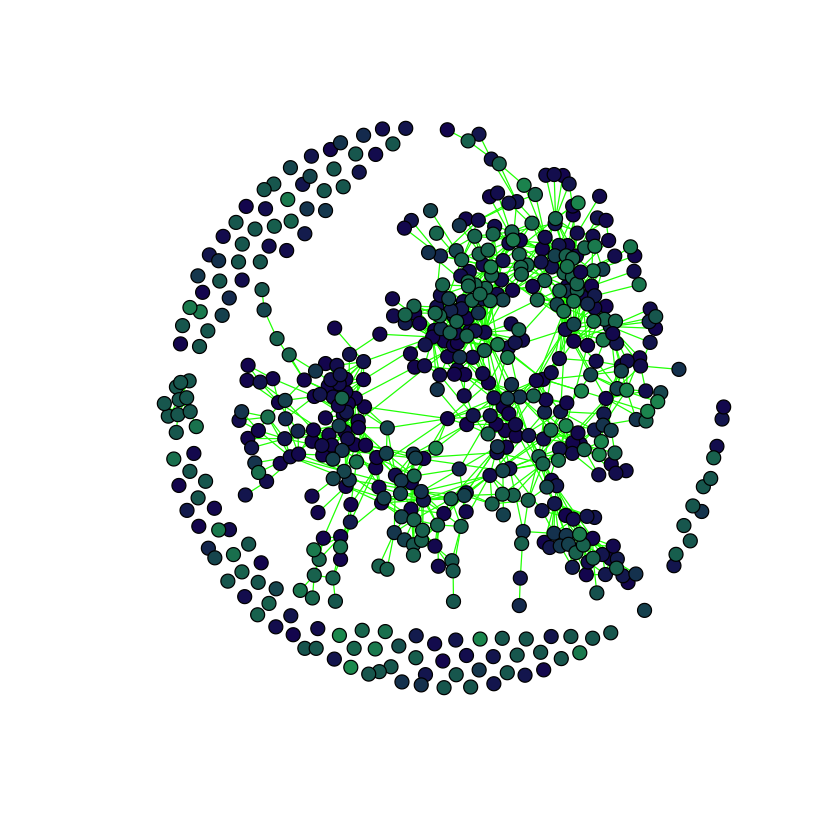

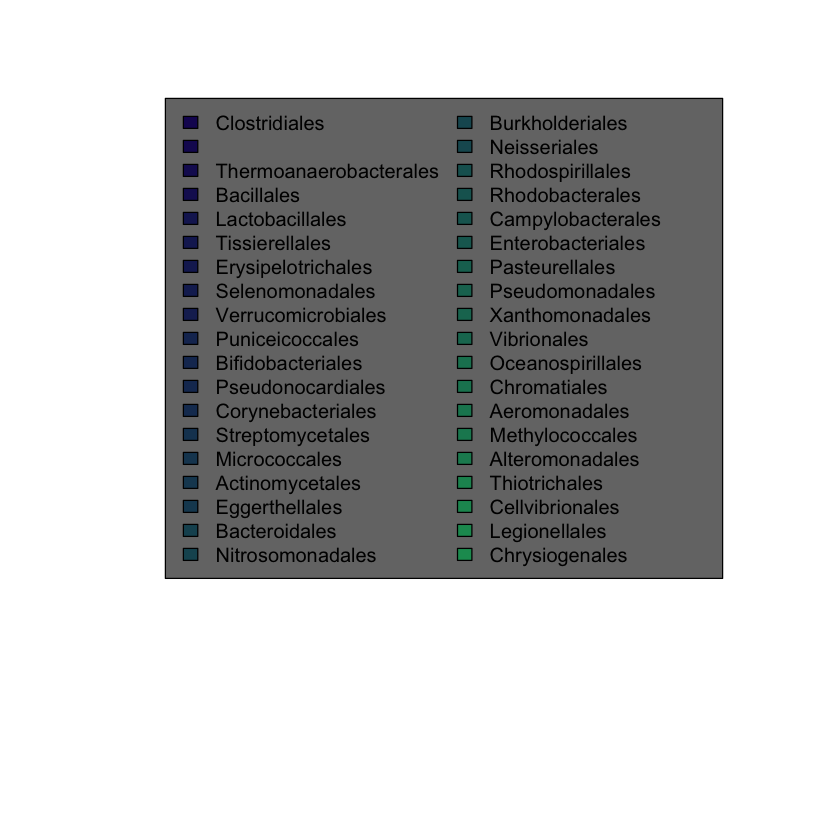

In [ ]:
plot.graph(adjacency.graph, taxmat_el, "Order")

</details>

The network is stored as an `igraph` object `adjacency.graph`, calculated in the code hidden by the dropdown.

In [ ]:
adjacency.graph

IGRAPH 36c88f2 U--- 565 1200 -- 
+ edges from 36c88f2:
 [1]  1--  2  1-- 76  2-- 77  2--195  3--324  4--528  5--221  5--479  5--480
[10]  5--526  5--534  5--542  5--553  5--563  7--244  7--261  7--299  7--479
[19]  7--485  7--526  8--  9  8-- 66  8-- 69  8-- 85  8--153  8--234  8--246
[28]  9-- 66  9-- 67  9-- 68  9-- 69  9--128  9--130  9--211 10-- 67 10--128
[37] 11-- 82 11--120 11--243 11--290 11--336 11--363 11--435 11--437 11--456
[46] 11--457 12--542 13-- 53 13-- 76 13--192 13--272 13--326 14--106 14--244
[55] 14--254 14--342 14--554 15-- 34 15-- 46 15--243 15--337 16-- 17 16--316
[64] 16--451 16--458 16--510 16--519 17-- 64 17--316 17--343 17--510 17--525
[73] 19-- 20 19-- 21 19-- 25 19-- 30 19-- 32 19-- 34 19-- 35 19-- 54 19-- 81
+ ... omitted several edges

Evaluating the assortativity of a graph is straightforward with the `igraph` package:

In [ ]:
get.assortativity.at.level <- function(adjacency.graph, taxmat, taxa.level) {
    groups <- as.integer(as.factor(taxmat[, taxa.level]))
    return(assortativity(adjacency.graph, groups))
}

get.assortativity.at.levels <- function(adjacency.graph, taxmat) {
    curried.assortativity <- function(taxa.level) get.assortativity.at.level(
        adjacency.graph,
        taxmat,
        taxa.level
    )
    return(
        lapply(
            colnames(taxmat),
            curried.assortativity
        )[2:length(colnames(taxmat))]
    )        
}

print.assortativity.performances <- function(adjacency.graph, taxmat) {
    for (taxa.level in colnames(taxmat)) {
        if (taxa.level == "Domain") {
            # Skip b/c everything in dataset has domain being bacteria
            # which will cause this to evaluate as NaN.
            next()
        }
        print(
            paste(
                taxa.level,
                ": ",
                get.assortativity.at.level(adjacency.graph, taxmat_el, taxa.level)
            )
        )
    }
}

In [ ]:
print.assortativity.performances(adjacency.graph, taxmat_el)

[1] "Phylum :  0.119028213625117"
[1] "Class :  0.114678278712612"
[1] "Order :  0.00101704475751504"
[1] "Family :  0.0227129118376968"
[1] "Genus :  0.0295176588068461"


It seems that the assortativity for <b style="color:#A6A440">order</b> is much lower than the rest, although the lower-taxa levels are all much lower than the high-taxa levels.  This would be expected as it is easier to accurately group things in a few larger groups than many smaller groups.

Unfortunately for us, this is very far away from the expected results.  We know from the last post that we had a lot more isolated vertices than in the paper, so maybe we should look at assortativity as a function of the regularization parameter.

In [ ]:
lambdas <- 10^seq(0, -2, by=-0.1)
precision.matrix.path <- huge(zs, lambda = lambdas)$path

Conducting Meinshausen & Buhlmann graph estimation (mb)....done


In [ ]:
library("ggplot2")
library("scales")

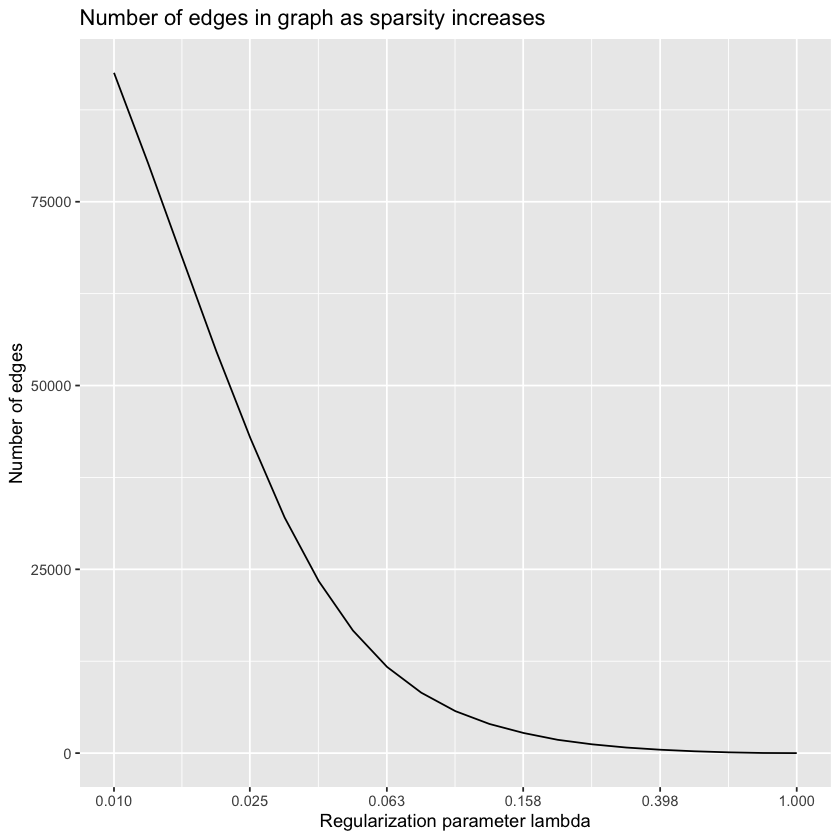

In [ ]:
sparsities <- sapply(precision.matrix.path, sum) / 2
ggplot(data.frame(sparsities), aes(lambdas, sparsities)) +
    geom_line() +
    scale_x_continuous(
        trans = "log10",
        breaks = round(
            lambdas[seq(1, length(lambdas), 4)],
            digits = 3
        )
    ) +
    ggtitle("Number of edges in graph as sparsity increases") +
    labs(x = "Regularization parameter lambda", y = "Number of edges")

In [ ]:
plot.all.assortativities <- function(path, taxmat, lambdas) {
    graphs <- lapply(
        lapply(path, graph.adjacency),
        as.undirected
    )
    assortativities <- lapply(
        graphs,
        function(graph) get.assortativity.at.levels(graph, taxmat)
    )

    # Remove first element as full of NaNs
    assortativities <- assortativities[2:length(assortativities)]
    lambdas.short <- lambdas[2:length(lambdas)]
    
    assortativities.1 <- as.numeric(lapply(assortativities, function(l) l[[1]]))
    assortativities.2 <- as.numeric(lapply(assortativities, function(l) l[[2]]))
    assortativities.3 <- as.numeric(lapply(assortativities, function(l) l[[3]]))
    assortativities.4 <- as.numeric(lapply(assortativities, function(l) l[[4]]))
    assortativities.5 <- as.numeric(lapply(assortativities, function(l) l[[5]]))
    ggplot(
        data.frame(assortativities.1),
        aes(x=lambdas.short)
    ) +
        geom_line(aes(y = assortativities.1, color = "Phylum")) +
        geom_line(aes(y = assortativities.2, color = "Class")) +
        geom_line(aes(y = assortativities.3, color = "Order")) +
        geom_line(aes(y = assortativities.4, color = "Family")) +
        geom_line(aes(y = assortativities.5, color = "Genus")) +
        scale_colour_manual("", 
            breaks = c("Phylum", "Class", "Order", "Family", "Genus"),
            values = c("black", "blue", "maroon", "red", "orange")
        ) +
        theme(legend.position = "top") +
        labs(x = "Regularization parameter lambda", y = "Assortativities") +
        ggtitle("Assortativities at different taxonomic levels")
}

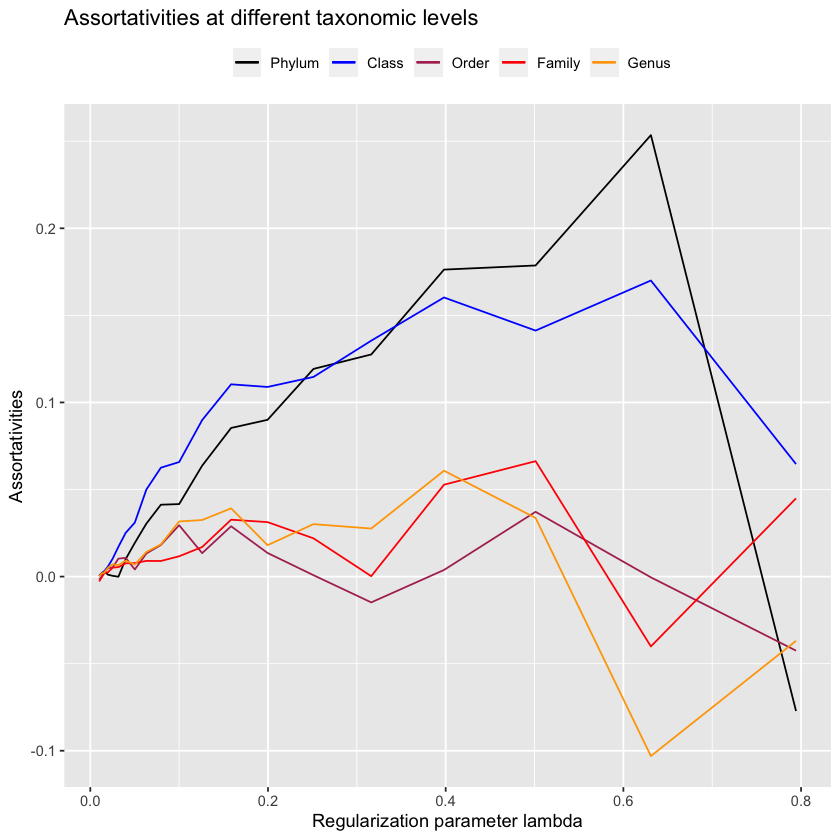

In [ ]:
plot.all.assortativities(precision.matrix.path, taxmat_el, lambdas)

Interestingly, <strong style="color:#C0CF96">at no point do we reproduce the assortativities seen in the paper</strong>.  This is easily seen because <b style="color:#A6A440">order</b> never reaches $0.10$, the value that is reported by @ZiLN.  Now, this may be because we're calculating the <b style="color:#A6A440">precision matrix</b> using the <b style="color:#EB1960">Meinshausen and Buhlmann</b> graph estimation method, the default in `igraph`.  Perhaps we would have better luck using the <b style="color:#EB1960">Graphical LASSO</b> method?  We know that @ZiLN use <b style="color:#EB1960">Meinshausen and Buhlmann</b> for their <b style="color:#EB1960">Figure 5</b> data, but they do not report their method for <b style="color:#EB1960">Figure 4</b> - the figure we're interested in - so it is reasonable to assume that they may have used <b style="color:#EB1960">Graphical LASSO</b> here (a method also used elsewhere in their paper).

In [ ]:
lambdas.glasso <- 10^seq(0, -2, by=-0.1)
glasso.path <- huge(zs, lambda = lambdas.glasso, method="glasso")$path

Conducting the graphical lasso (glasso) wtih lossless screening....in progress: 95%
Conducting the graphical lasso (glasso)....done.                                          


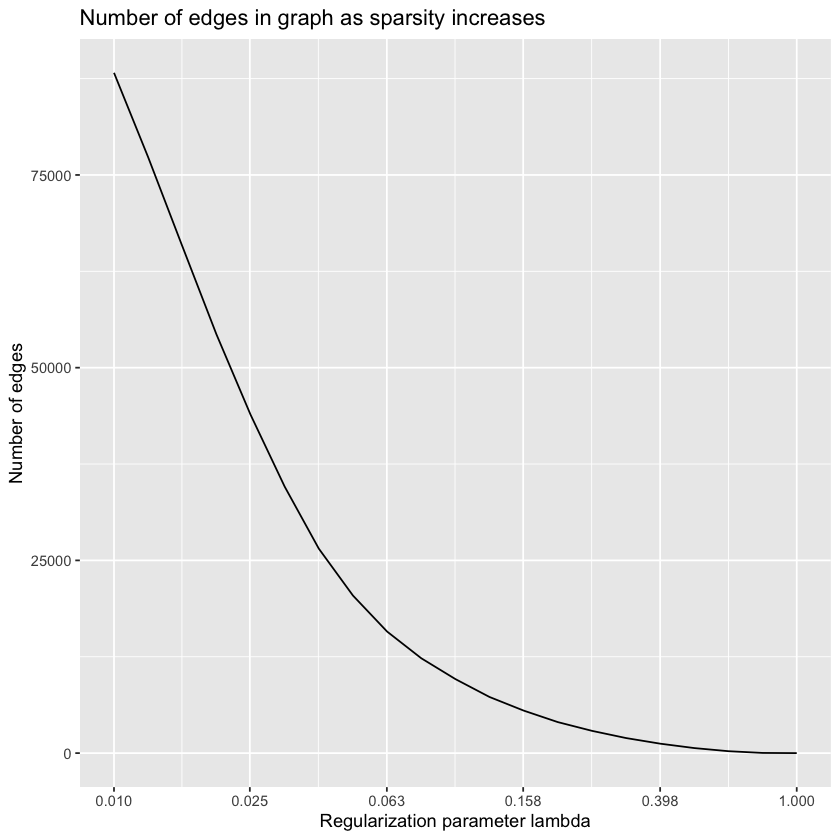

In [ ]:
sparsities <- sapply(glasso.path, sum) / 2
ggplot(data.frame(sparsities), aes(lambdas.glasso, sparsities)) +
    geom_line() +
    scale_x_continuous(
        trans = "log10",
        breaks = round(
            lambdas.glasso[seq(1, length(lambdas.glasso), 4)],
            digits = 3
        )
    ) +
    ggtitle("Number of edges in graph as sparsity increases") +
    labs(x = "Regularization parameter lambda", y = "Number of edges")

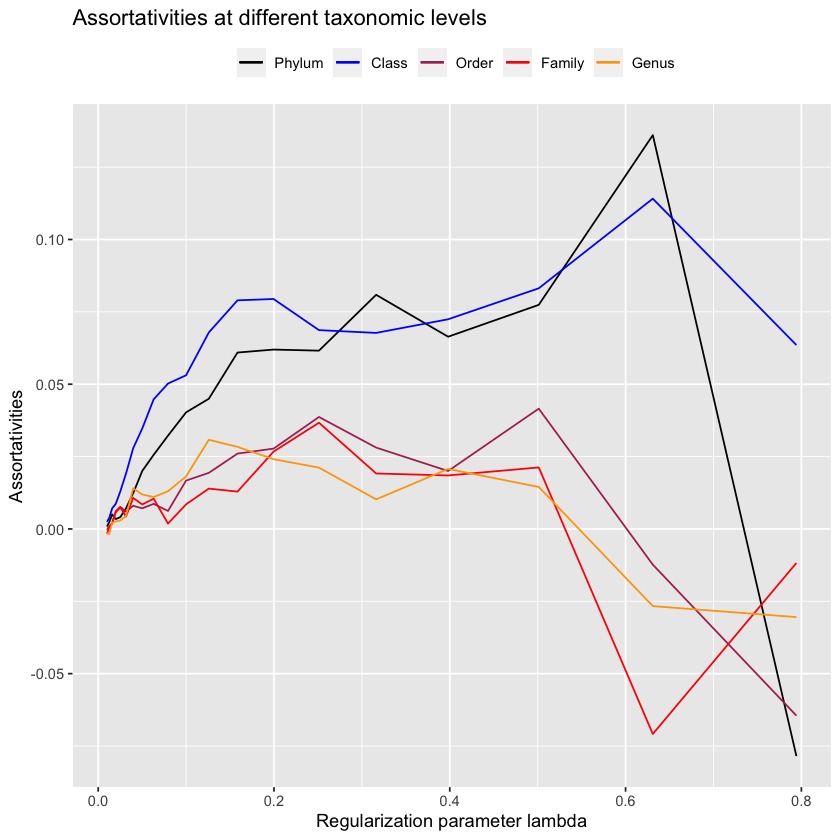

In [ ]:
plot.all.assortativities(glasso.path, taxmat_el, lambdas.glasso)

No - `glasso` performs much notably worse!  Maybe we just didn't have the resolution with `mb` to find the point where the <b style="color:#A6A440">assortativity</b> for <b style="color:#A6A440">order</b> reached $0.10$?

In [ ]:
lambdas.mb.2 <- 10^seq(0, -2, by=-0.05)
mb.2 <- huge(zs, lambda = lambdas.mb.2)$path

Conducting Meinshausen & Buhlmann graph estimation (mb)....done


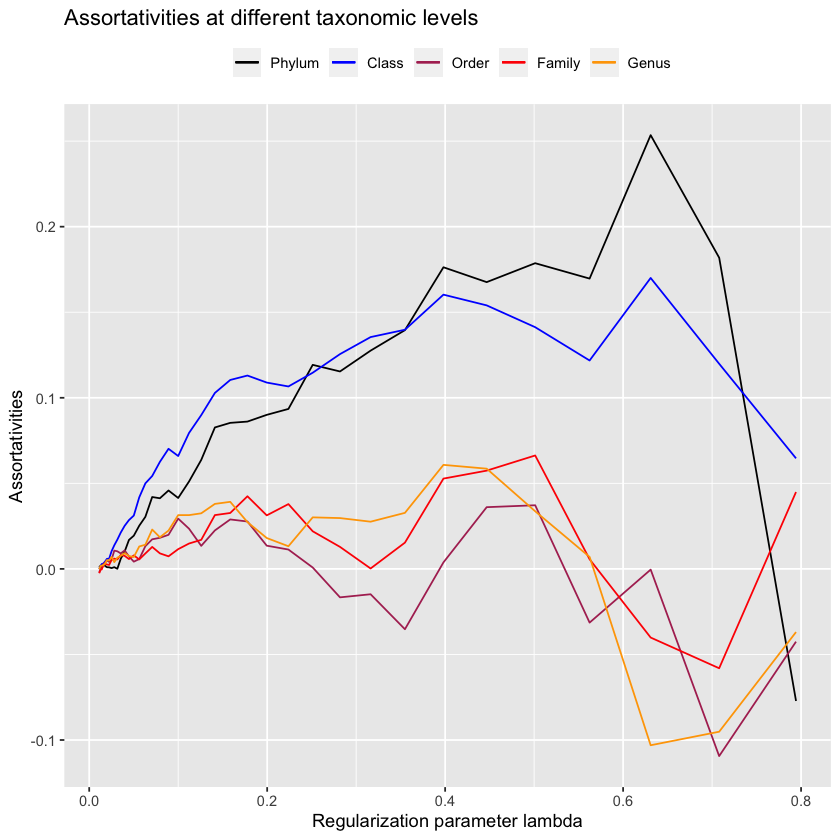

In [ ]:
plot.all.assortativities(mb.2[2:40], taxmat_el, lambdas.mb.2[2:40])

Unfortunately, I can't really replicate their assortativity results, and their [github](https://github.com/vincentprost/Zi-LN) doesn't contain code to replicate it either!

Which is quite frustrating.  Anyways, I have my own <b style="color:#EB1960">GLasso</b> method, <b style="color:#EB1960">antGLasso</b>, so I want to try it.  It's experimental so it doesn't have an R interface, making it difficult to use in this R notebook, so I'll just export the `zs`, run it on them, and bring it back here.

In [ ]:
write.csv(zs, "./localdata/computed_zs.csv")

In [ ]:
antGLasso.mat <- as.matrix(
    read.csv(
        "./localdata/antGLasso-output.csv",
        header=FALSE,
        col.names=paste0("C", 1:565)
    )
)

<b style="color:#EB1960">antGLasso</b> regularizes by computing the full solution and then thresholding.  For the previous methods I capped out at keeping the top ~100000 edges, so we'll do the same here.

In [ ]:
upper.bound <- 20
lower.bound <- 0.01
sum(abs(antGLasso.mat) > upper.bound) / 2
sum(abs(antGLasso.mat) > lower.bound) / 2

[1] 14.5

[1] 131390

From the above, we can see that its reasonable to start with a threshold of $0.4$ and continue to a threshold of $607$.

In [ ]:
lambdas.antGLasso <- exp(0:19 * (log(upper.bound) - log(lower.bound)) / 19 + log(lower.bound))

In [ ]:
threshold.matrix <- function(mat., threshold) {
    mat <- matrix(0, dim(mat.)[[1]], dim(mat.)[[2]])
    mat[abs(mat.) < threshold] = 0
    mat[abs(mat.) > threshold] = 1
    diag(mat) <- 0
    return(mat)
}

In [ ]:
antGLasso.path <- lapply(
    lambdas.antGLasso,
    function(thresh) threshold.matrix(antGLasso.mat, thresh)
)

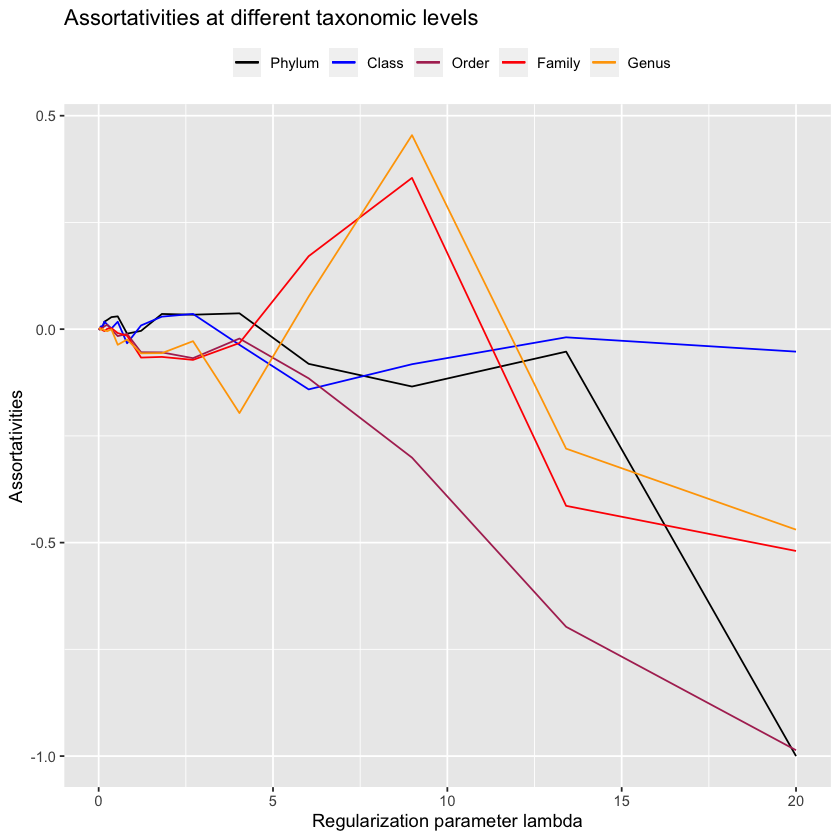

In [ ]:
plot.all.assortativities(antGLasso.path, taxmat_el, lambdas.antGLasso)

<details>
    <summary><b style="color:#C0CF96">See the plots produced</b></summary>

In [ ]:
lambdas.antGLasso

[1]  0.01000000  0.01491896  0.02225752  0.03320590  0.04953974  0.07390811
 [7]  0.11026318  0.16450115  0.24541854  0.36613883  0.54624089  0.81493436
[13]  1.21579695  1.81384207  2.70606293  4.03716326  6.02302593  8.98572564
[19] 13.40576416 20.00000000

Best <b style="color:#EB1960">assortativity</b> for low level connections:

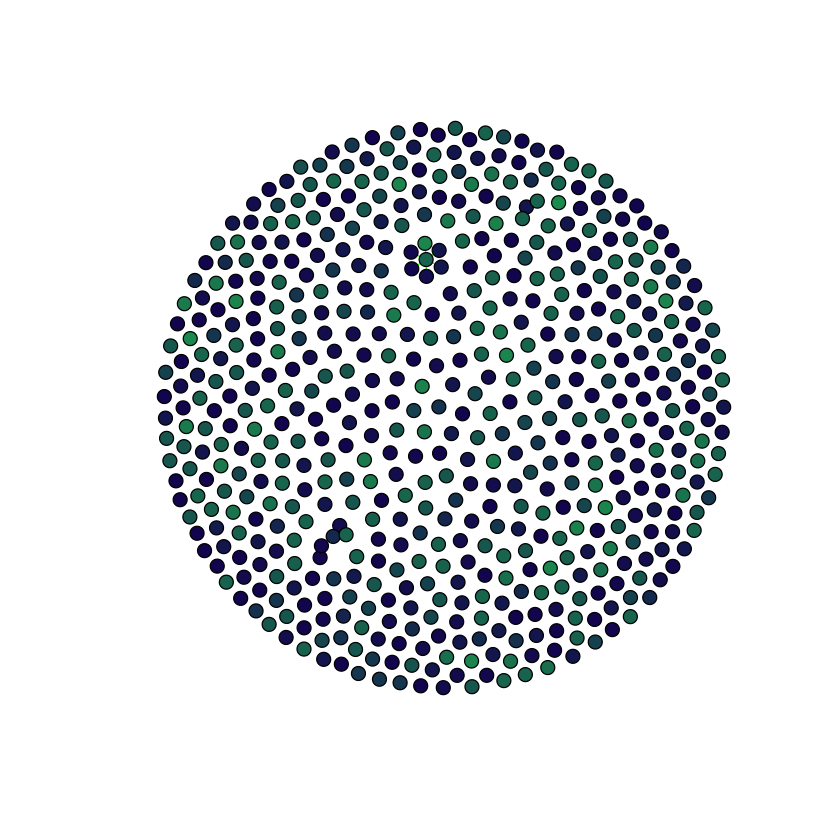

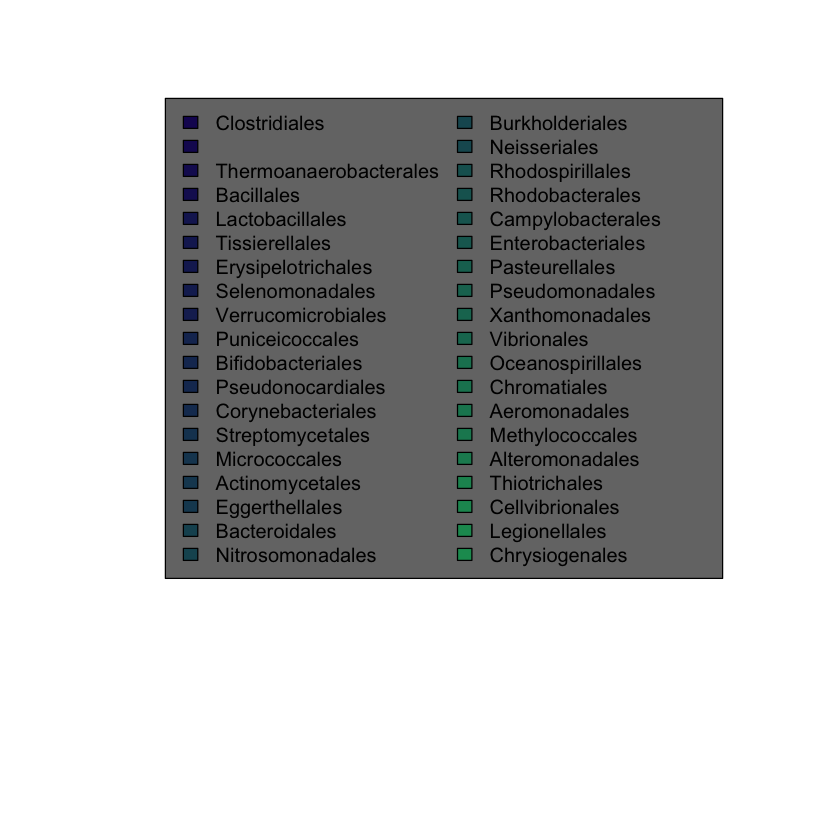

In [ ]:
plot.graph(
    graph.adjacency(
        antGLasso.path[[18]],
        mode = "Undirected"
    ),
    taxmat_el,
    "Order"
)

<b style="color:#EB1960">Assortativity</b> for the less sparse (still sparse though) situation

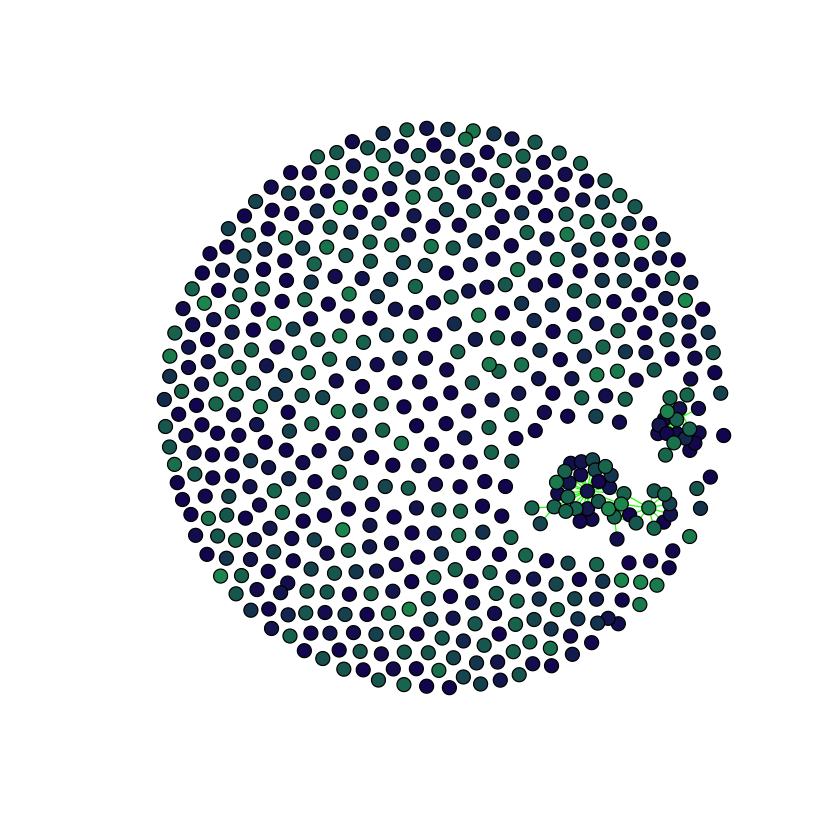

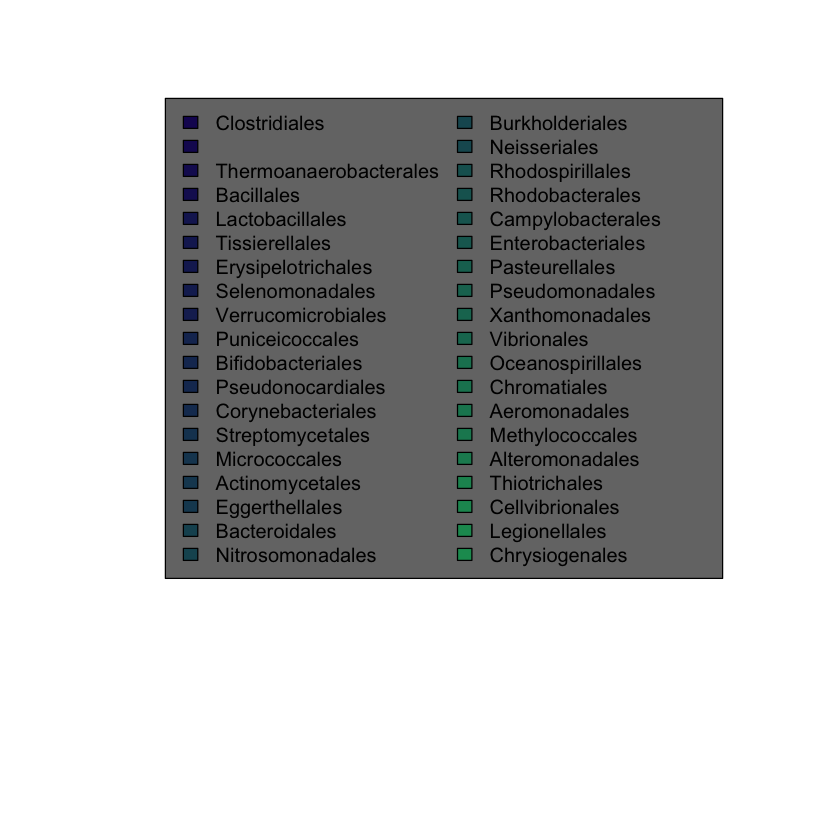

In [ ]:
plot.graph(
    graph.adjacency(
        antGLasso.path[[15]],
        mode = "Undirected"
    ),
    taxmat_el,
    "Order"
)

</details>

Let's zoom our <b style="color:#A6A440">assortativity</b> plot into what's happening before it gets very sparse.

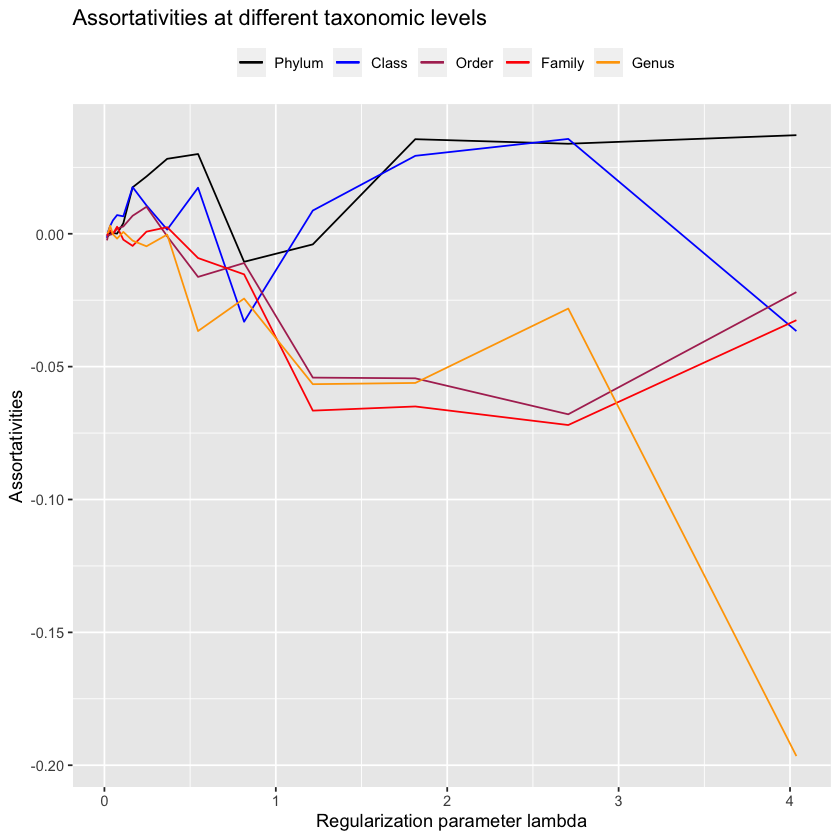

In [ ]:
idcs <- lambdas.antGLasso < 5
plot.all.assortativities(antGLasso.path[idcs], taxmat_el, lambdas.antGLasso[idcs])

It seems that once it gets very sparse, our method does well on the low-level taxonomies - these will be the edges that <b style="color:#EB1960">antGLasso</b> most confidently believes are correct, so its nice to know that it is indeed correct.  However, due to the extreme sparsity in those situations its not very useful.  When looking at more reasonably sparsified situations, <b style="color:#EB1960">antGLasso</b> does terrible.  Not only does it not have substantial <b style="color:#A6A440">assortativity</b> for the higher taxonomic levels, but the low-level taxonomies have <strong style="color:#C0CF96">negative</strong> <b style="color:#A6A440">assortativity</b>.

<details>
    <summary><b style="color:#C0CF96">Other, failed, attempts with</b> <b style="color:#EB1960">antGLasso</b></summary>

One more thing we can try before being sad is to only look at the negative values in the <b style="color:#A6A440">precision matrix</b> as they carry special meaning.

In [ ]:
antGLasso.negs <- matrix(0, 565, 565)
antGLasso.negs[antGLasso.mat < 0] <- abs(antGLasso.mat[antGLasso.mat < 0])
antGLasso.negs[antGLasso.mat > 0] <- 0
diag(antGLasso.negs) <- 0

In [ ]:
upper.bound.negs <- 1
lower.bound.negs <- 0.0001
sum(antGLasso.negs > upper.bound.negs) / 2
sum(antGLasso.negs > lower.bound.negs) / 2

[1] 379

[1] 87434

In [ ]:
lambdas.antGLasso.negs <- exp(
    0:19 * (log(upper.bound.negs) - log(lower.bound.negs)) / 19 + log(lower.bound.negs)
)

In [ ]:
antGLasso.path.negs <- lapply(
    lambdas.antGLasso.negs,
    function(thresh) threshold.matrix(antGLasso.negs, thresh)
)

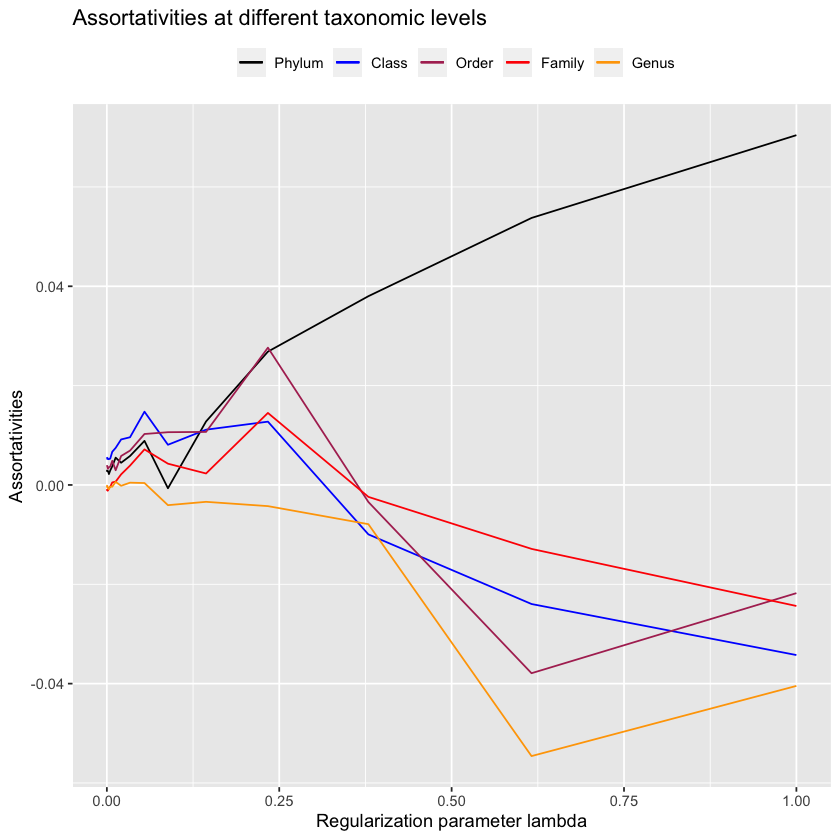

In [ ]:
plot.all.assortativities(antGLasso.path.negs, taxmat_el, lambdas.antGLasso.negs)

Unfortunately it should be fairly clear that this doesn't work.  Maybe we can look at the inverse, which corresponds to the <b style="color:#A6A440">covariance matrix</b>?

In [ ]:
antGLasso.inv <- solve(antGLasso.mat)

In [ ]:
upper.bound.inv <- 1
lower.bound.inv <- 0.005
sum(abs(antGLasso.inv) > upper.bound.inv) / 2
sum(abs(antGLasso.inv) > lower.bound.inv) / 2

[1] 159.5

[1] 96350.5

In [ ]:
lambdas.antGLasso.inv <- exp(
    0:19 * (log(upper.bound.inv) - log(lower.bound.inv)) / 19 + log(lower.bound.inv)
)

In [ ]:
antGLasso.path.inv <- lapply(
    lambdas.antGLasso.inv,
    function(thresh) threshold.matrix(antGLasso.inv, thresh)
)

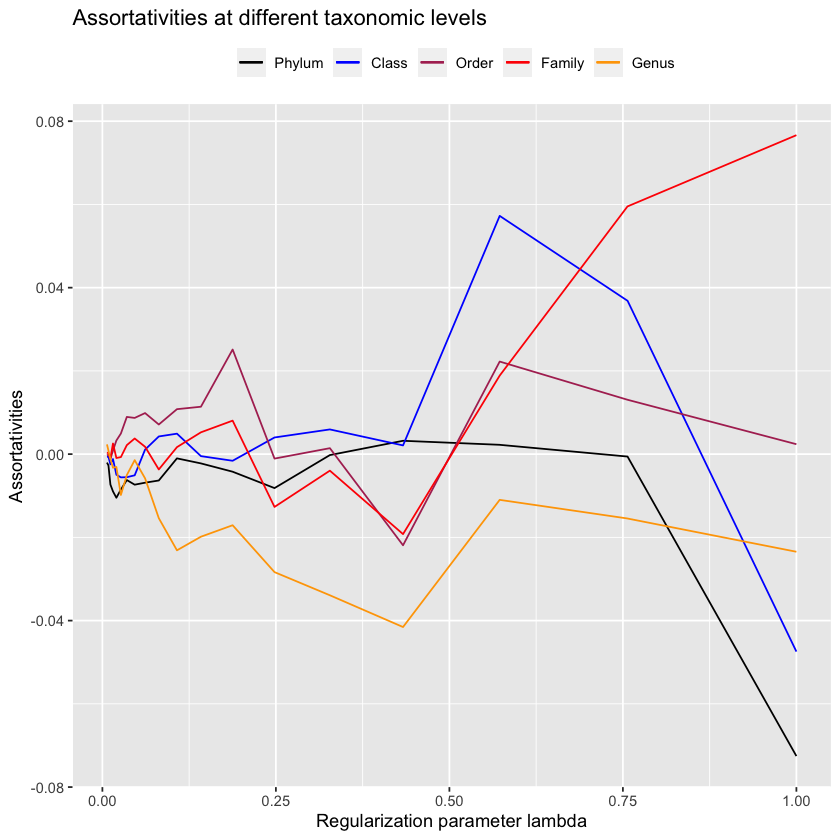

In [ ]:
plot.all.assortativities(antGLasso.path.inv, taxmat_el, lambdas.antGLasso.inv)

Still we don't quite achieve the desired values.  The evidence is clear; <b style="color:#EB1960">antGLasso</b> is objectively worse at finding high-<b style="color:#A6A440">assortativity</b> graphs.

</details>

Once again, a paper replication blog post ends on a bit of a downer, this time twofold:

1) We were unable to get quite as good results as @ZiLN, although we got close enough to know their method worked
2) My custom method absolutely failed to get even halfway-decent results.

Such is life.